In [1]:
import mariadb
import sys

# Connect to MariaDB Platform
try:
    conn = mariadb.connect(
        user="root",
        password="root",
        host="localhost",
        port=3306,
        database="smart_factory"
    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

# Get Cursor
cur = conn.cursor()

In [30]:
cur.execute("select * from `2020_raw`")
x = cur.fetchall()

In [31]:
import pandas as pd
df = pd.DataFrame(x)
df = df.iloc[:,[0,2,3]]
df.columns = ['SOLDDATE','PRODNAME','QUANT']
df

,SOLDDATE,PRODNAME,QUANT
0,20/01/01,AE,9500
1,20/01/01,CSA4000,1900
2,20/01/01,CSA5000,7600
3,20/01/01,PEMA-HR1000,9500
4,20/01/01,PEMA-HR1000,6650
...,...,...,...
9859,20/12/31,PEMA-SR3000F,5700
9860,20/12/31,PEMA-HR1000,9500
9861,20/12/31,PEMA-HR1000,6650
9862,20/12/31,PEMA-HR1000,2850


In [32]:
df_AE = df[df.PRODNAME == 'AE'].drop('PRODNAME',axis=1).groupby('SOLDDATE').sum()
df_AE

,QUANT
SOLDDATE,
20/01/01,9500
20/01/02,2850
20/01/04,1460
20/01/09,3650
20/01/10,730
...,...
20/12/20,4750
20/12/24,1900
20/12/25,9500


In [33]:
# AE는 정상성을 만족?
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
adf_test(df_AE)

Results of Dickey-Fuller Test:
Test Statistic                -7.595933e+00
p-value                        2.460499e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


In [34]:
# 이 검정에서도 정상성을 만족
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
kpss_test(df_AE)

Results of KPSS Test:
Test Statistic           0.118429
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\admin\Anaconda3\envs\cakd5\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<AxesSubplot:xlabel='SOLDDATE'>

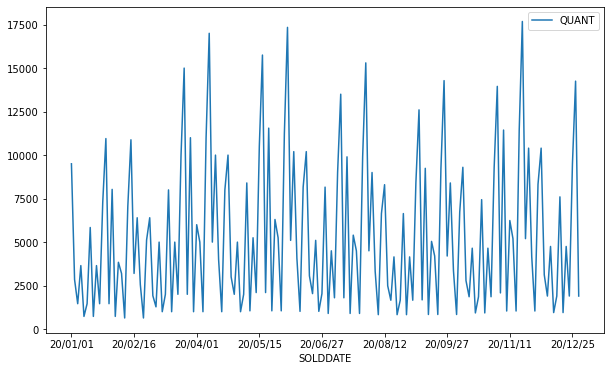

In [35]:
# 그래프로 확인
df_AE.plot(figsize=(10,6))

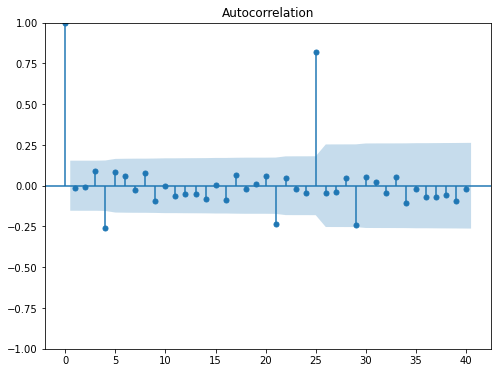

In [36]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(df_AE, lags=40, ax=ax)
plt.show()

In [9]:
cur.execute("select * from `2021_raw`")
x = cur.fetchall()

In [10]:
import pandas as pd
df2 = pd.DataFrame(x)
df2 = df2.iloc[:,[0,2,4]]
df2.columns = ['SOLDDATE','PRODNAME','QUANT']
df2

,SOLDDATE,PRODNAME,QUANT
0,2021-01-01,PEMA-HR1500,3800
1,2021-01-01,PEMA-SN400,9500
2,2021-01-01,PEMA-SN400,9500
3,2021-01-01,PEMA-SR2000,1900
4,2021-01-01,PEMA-SR2000,9500
...,...,...,...
2394,2021-03-31,PEMA-SR3000F,500
2395,2021-03-31,PEMA-SR3000F,4500
2396,2021-03-31,PEMA-HR1000,3000
2397,2021-03-31,PEMA-HR1500,10000


In [11]:
df_AE2 = df2[df2.PRODNAME == 'AE'].drop('PRODNAME',axis=1)
df_AE2 = df_AE2.set_index('SOLDDATE')
df_AE2

,QUANT
SOLDDATE,
2021-01-02,950
2021-01-02,9500
2021-01-03,950
2021-01-06,4380
2021-01-07,730
...,...
2021-03-20,2000
2021-03-24,10000
2021-03-25,1000


In [12]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_AE, order = (1,0,0)).fit()
model.summary()

C:\Users\admin\Anaconda3\envs\cakd5\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\Anaconda3\envs\cakd5\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\Anaconda3\envs\cakd5\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\Anaconda3\envs\cakd5\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dat

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  QUANT   No. Observations:                  285
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2669.450
Date:                Mon, 11 Apr 2022   AIC                           5344.899
Time:                        14:08:27   BIC                           5355.857
Sample:                             0   HQIC                          5349.292
                                - 285                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3015.8596    315.073      9.572      0.000    2398.327    3633.392
ar.L1         -0.0671      0.059     -1.131      0.258      -0.183       0.049
sigma2      7.881e+06   1.11e+06      7.125      0.000    5.71e+06       1e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               111.80
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             1.47
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\admin\Anaconda3\envs\cakd5\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


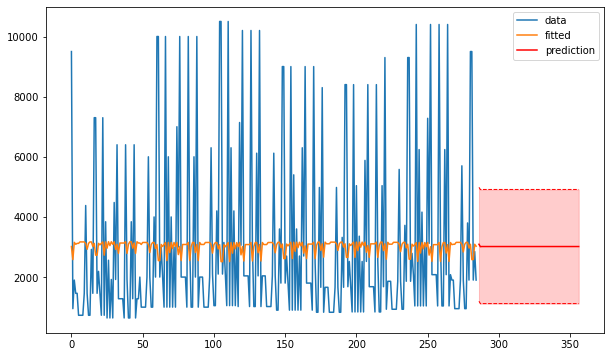

In [22]:
fig = plt.figure(figsize=(10,6))
fig.set_facecolor('white')
 
fitted_values = model.fittedvalues ## in-sample prediction
 
## prediction
k = 71
 
forecast = model.get_forecast(k) ## out-of-sample prediction
predicted_values = forecast.predicted_mean
prediction_intervals = forecast.conf_int(alpha=0.5)
upper_limit = [x for x in prediction_intervals.iloc[:,0]]
lower_limit = [x for x in prediction_intervals.iloc[:,1]]
 
pred_x = range(len(df_AE)+1, len(df_AE)+k+1)
 
plt.plot(range(len(df_AE)), df_AE, label = 'data')
plt.plot(range(len(df_AE)), fitted_values, label='fitted')
plt.plot(pred_x,predicted_values,color='red',label='prediction')
plt.plot(pred_x,lower_limit,color='red',linestyle='--',linewidth=1)
plt.plot(pred_x,upper_limit,color='red',linestyle='--',linewidth=1)
plt.fill_between(pred_x,lower_limit,upper_limit,color='red',alpha=0.2)
plt.legend()
 
plt.show()

In [20]:
forecast